# A


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb

In [15]:
data = pd.read_csv('./AirIndia (Domestic).csv')

In [16]:
data.columns = data.columns.str.strip().str.replace(r'\n|\(TH\)|#|\(|\)', '', regex=True).str.replace(' ', '_')


In [17]:
# Combining 'Month' and 'FY' into a single column
data['Month_Year'] = data['Month'] + ' ' + data['FY'].str[-2:]
data['Month_Year'] = pd.to_datetime(data['Month_Year'], format='%b %y', errors='coerce')


data['Month_Year'] = data.apply(
    lambda row: pd.to_datetime(row['Month'] + ' ' + str(int(row['FY'][-2:]) + 1), format='%b %y', errors='coerce') if pd.isna(row['Month_Year']) else row['Month_Year'], axis=1)
data['Month_Year'] = data['Month_Year'].fillna(method='bfill')

data = data.drop(columns=['Month', 'FY'])
data.set_index('Month_Year', inplace=True)

/var/folders/_d/ms_vv74d6fzcnc8gjr3s02_c0000gn/T/ipykernel_10741/1077653423.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Month_Year'] = data['Month_Year'].fillna(method='bfill')


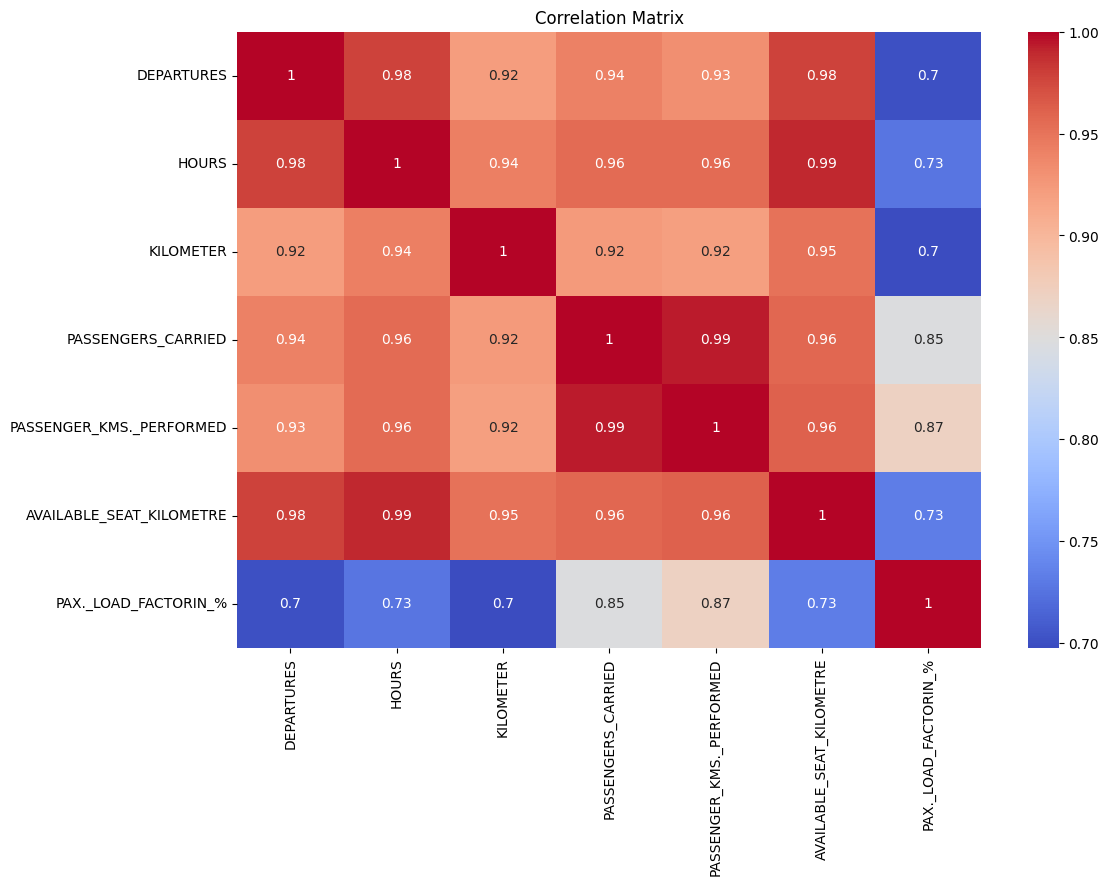

In [18]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
data.columns

Index(['DEPARTURES', 'HOURS', 'KILOMETER', 'PASSENGERS_CARRIED',
       'PASSENGER_KMS._PERFORMED', 'AVAILABLE_SEAT_KILOMETRE',
       'PAX._LOAD_FACTORIN_%'],
      dtype='object')

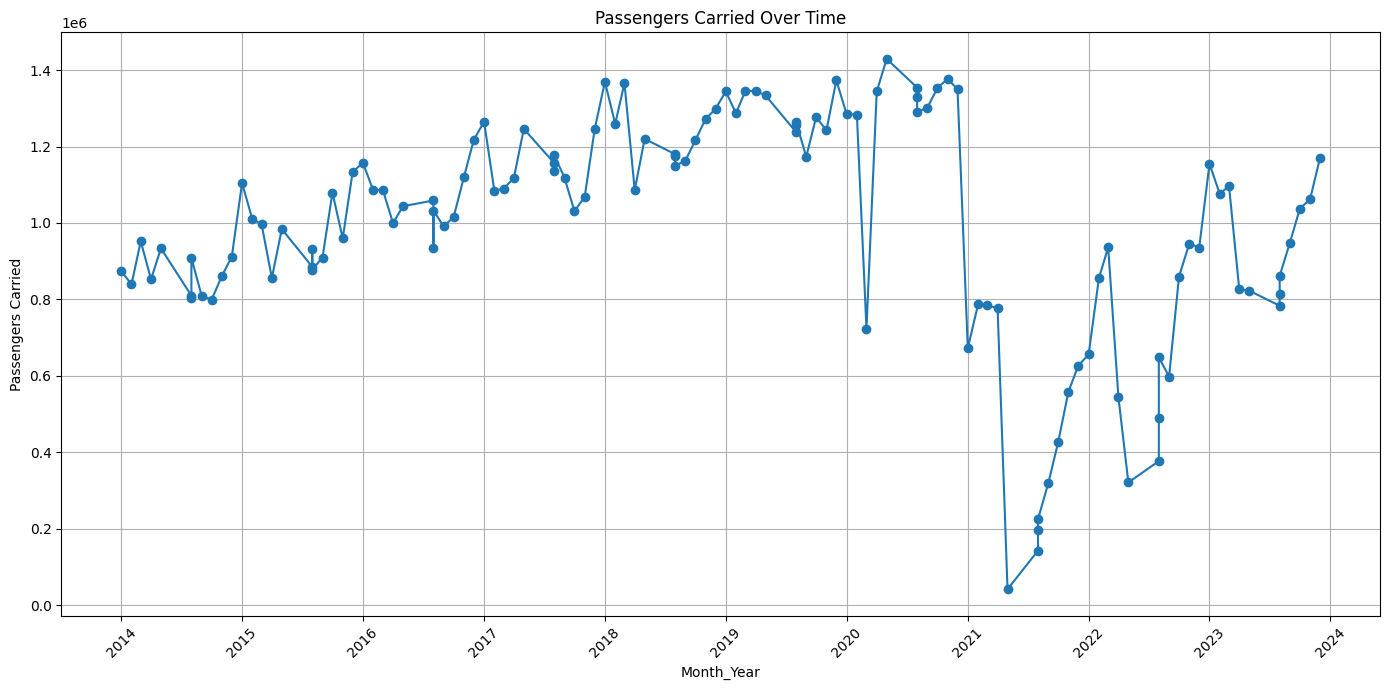

In [25]:
data_reset = data.reset_index()
data_reset = data_reset.sort_values(by='Month_Year')

plt.figure(figsize=(14, 7))
plt.plot(data_reset['Month_Year'], data_reset['PASSENGERS_CARRIED'], marker='o', linestyle='-')
plt.title('Passengers Carried Over Time')
plt.xlabel('Month_Year')
plt.ylabel('Passengers Carried')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

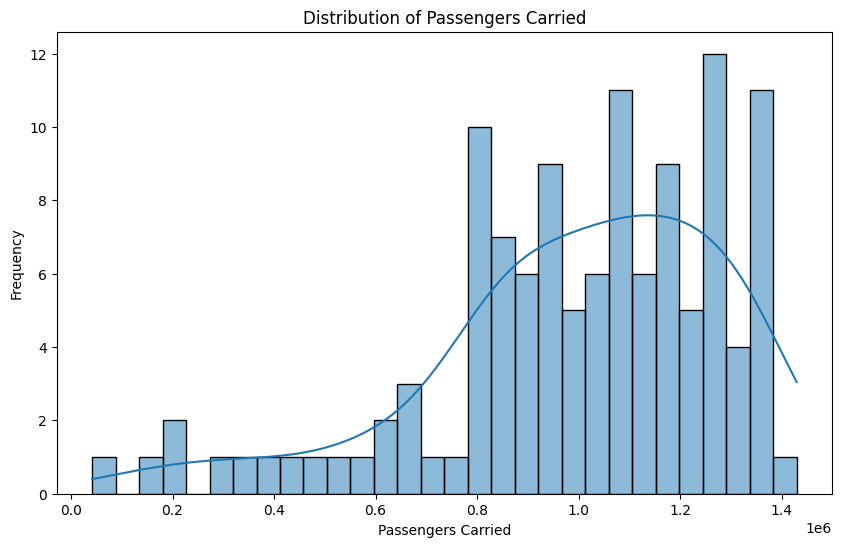

In [8]:
# Distribution of Passengers Carried
plt.figure(figsize=(10, 6))
sns.histplot(data['PASSENGERS_CARRIED'], bins=30, kde=True)
plt.title('Distribution of Passengers Carried')
plt.xlabel('Passengers Carried')
plt.ylabel('Frequency')
plt.show()

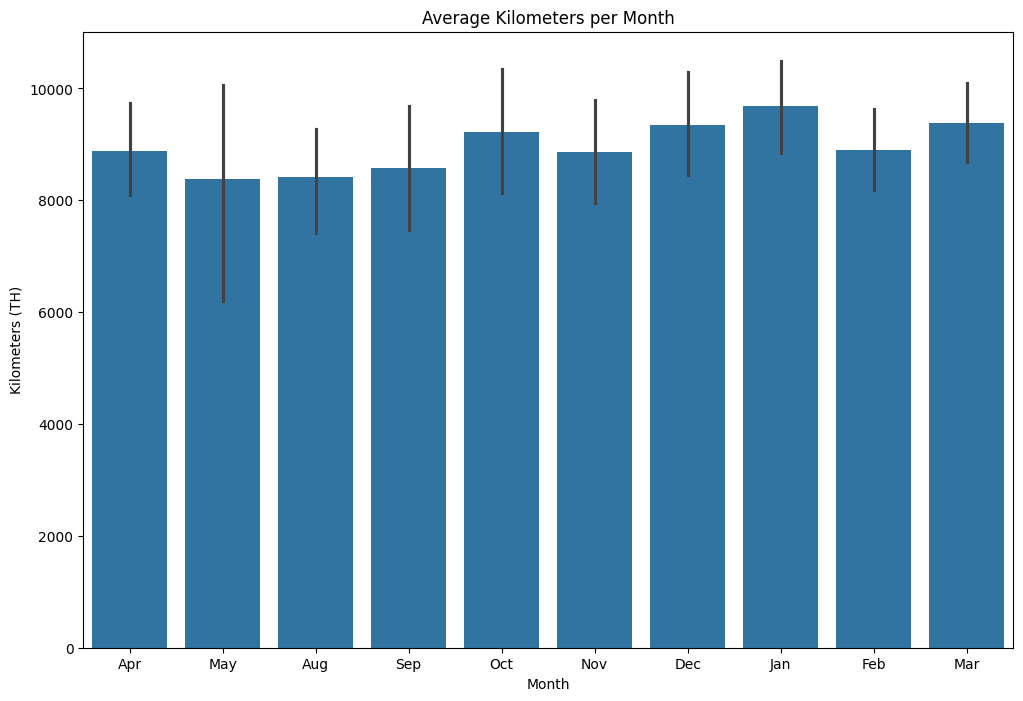

In [22]:
data_reset = data.reset_index()
data_reset['Month'] = data_reset['Month_Year'].dt.strftime('%b')

plt.figure(figsize=(12, 8))
sns.barplot(data=data_reset, x='Month', y='KILOMETER')
plt.title('Average Kilometers per Month')
plt.xlabel('Month')
plt.ylabel('Kilometers (TH)')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['DEPARTURES', 'HOURS', 'KILOMETER', 'PASSENGERS_CARRIED',
       'PASSENGER_KMS._PERFORMED', 'AVAILABLE_SEAT_KILOMETRE',
       'PAX._LOAD_FACTORIN_%'],
      dtype='object')
Mean Squared Error: 1657988023.2547302
R-squared: 0.980596761271257


<Figure size 1200x800 with 0 Axes>

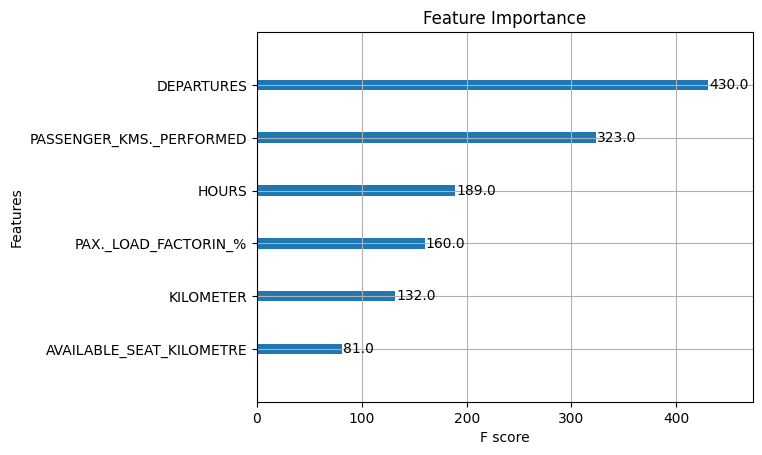

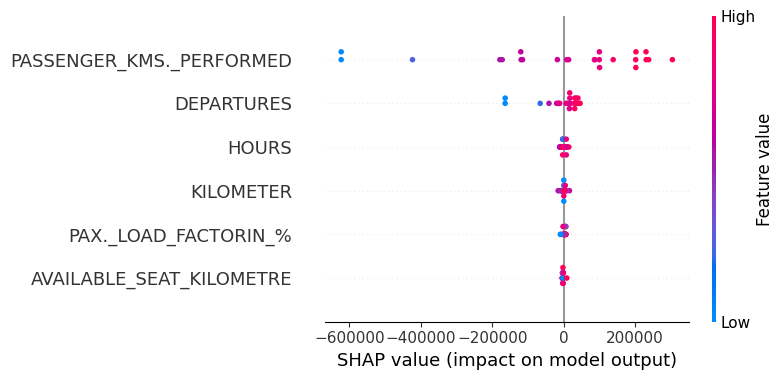

In [13]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

# Feature Engineering
X = data[['DEPARTURES', 'HOURS', 'KILOMETER', 'PASSENGER_KMS._PERFORMED', 'AVAILABLE_SEAT_KILOMETRE', 'PAX._LOAD_FACTORIN_%']]
y = data['PASSENGERS_CARRIED']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Feature Importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='weight')
plt.title('Feature Importance')
plt.show()

# SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test)
plt.show()
